In [23]:
import pprintpp
pprintpp.monkeypatch()

import sys
import os
sys.path.append(os.path.abspath(".."))

import re
import multiprocessing
from collections import Counter
import itertools
import pickle
import json
from IPython.display import display as disp
from sklearn.tree import export_graphviz 
from sklearn.tree import DecisionTreeClassifier
import graphviz 
import subprocess

import numpy as np
# import bottleneck as bn
import pandas as pd
import networkx as nx
import igraph as ig
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.cm.rocket.set_bad([0.01060815, 0.01808215, 0.10018654])
sns.set(context='paper', style='whitegrid', color_codes=True, font_scale=1.8)
colorcycle = [(0.498, 0.788, 0.498),
              (0.745, 0.682, 0.831),
              (0.992, 0.753, 0.525),
              (0.220, 0.424, 0.690),
              (0.749, 0.357, 0.090),
              (1.000, 1.000, 0.600),
              (0.941, 0.008, 0.498),
              (0.400, 0.400, 0.400)]
%matplotlib inline
sns.set_palette(colorcycle)

# import warnings
# warnings.simplefilter("ignore", category=DeprecationWarning)
# warnings.simplefilter("ignore", category=mpl.cbook.mplDeprecation)
# warnings.simplefilter("ignore", category=UserWarning)


from speclib import misc, loaders, graph, plotting

pd.set_option('display.max_rows', 55)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 1000)
np.set_printoptions(linewidth=145)

mpl.rcParams['figure.max_open_warning'] = 65
mpl.rcParams['text.usetex'] = True 
mpl.rcParams['figure.figsize'] = [12, 7] 

# import pixiedust

/lscr_paper/allan/miniconda3/envs/py36up/lib/python3.6/site-packages/pprintpp/__init__.py:171: UserWarning: 'pprint' has already been imported; monkeypatching won't work everywhere.
  warnings.warn("'pprint' has already been imported; monkeypatching "


In [7]:
! /lscr_paper/allan/bin_allan/exa -l *.pkl

.rw-rw-r--  21k bzg778 26 Jul  1:51 usermove_statechange.pkl
.rw-rw-r-- 399M bzg778 13 Aug  5:26 userMovement_adaboost_coarse.pkl
.rw-rw-r-- 357M bzg778 21 Aug 13:57 userMovement_cv_GradientBoostingClassifier.pkl
.rw-rw-r-- 356M bzg778 31 Jul 22:35 userMovement_cv_subgrid_search.pkl
.rw-rw-r-- 461M bzg778 31 Jul 22:09 userMovement_rf_coarse.pkl
.rw-rw-r-- 667M bzg778  1 Aug 14:54 userMovement_rf_finer.pkl
.rw-rw-r-- 356M bzg778 31 Jul 15:17 userMovement_sgd_std_final_coarse.pkl


In [8]:
with open('userMovement_cv_GradientBoostingClassifier.pkl', 'br') as fid:
    gbc = pickle.load(fid)

In [115]:
columns = [f"{cha}{qrt}" for cha in "csgb" for qrt in range(1, 9)]
columns = pd.Index(columns).str.upper()

In [24]:
gbc.best_estimator_

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.5, loss='deviance', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=156, presort=True,
              random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [25]:
gbc.validation_auc_score

0.8590484332634439

In [117]:
gbc.best_score_

0.8584678684923261

In [118]:
gbc.validation_auc_score - gbc.best_score_

0.0005805647711177864

In [119]:
est = gbc.best_estimator_

In [139]:
dfi = pd.DataFrame(est.feature_importances_, index=columns, columns=['Feature importance'])
dfi['cat'] = dfi.index.str[0]# .str.upper() 
dfi = dfi.sort_values('Feature importance', ascending=False) 
dfi.head() 

,Feature importance,cat
B7,0.116868,B
B3,0.062492,B
G7,0.054269,G
G3,0.045004,G
C3,0.042471,C


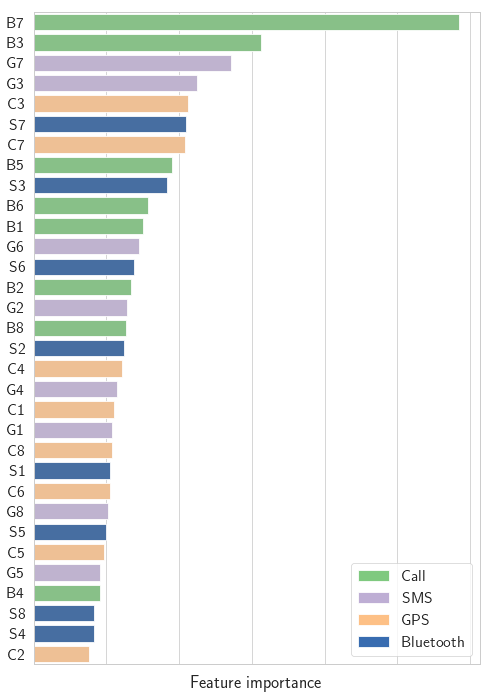

In [280]:
fig, ax = plt.subplots(figsize=(8, 12))
bars = sns.barplot(data=dfi, x='Feature importance', y=dfi.index,
                   hue='cat', dodge=False, ax=ax, orient='h')
custom_lines = [mpl.patches.Patch(facecolor=colorcycle[0]),
                mpl.patches.Patch(facecolor=colorcycle[1]), 
                mpl.patches.Patch(facecolor=colorcycle[2]),
                mpl.patches.Patch(facecolor=colorcycle[3])]
ax.legend(custom_lines, ["Call", "SMS", "GPS", "Bluetooth"], loc="lower right")
ax.set_xticklabels(el.get_text().upper() for el in ax.get_xticklabels())
fig.savefig('figs/graadient_boosted_trees_variable_importance.pdf')

In [146]:
gbc.best_params_

{'learning_rate': 0.5, 'max_depth': 5, 'n_estimators': 156}

In [149]:
est.estimators_[0] 

array([DecisionTreeRegressor(criterion='friedman_mse', max_depth=5,
           max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=True,
           random_state=<mtrand.RandomState object at 0x7fbfa2b7e2d0>,
           splitter='best')], dtype=object)

In [151]:
[el for el in dir(est) if (el.endswith('_') and not el.startswith('_'))] 

['classes_',
 'estimators_',
 'feature_importances_',
 'init_',
 'loss_',
 'max_features_',
 'n_classes_',
 'n_features_',
 'train_score_']

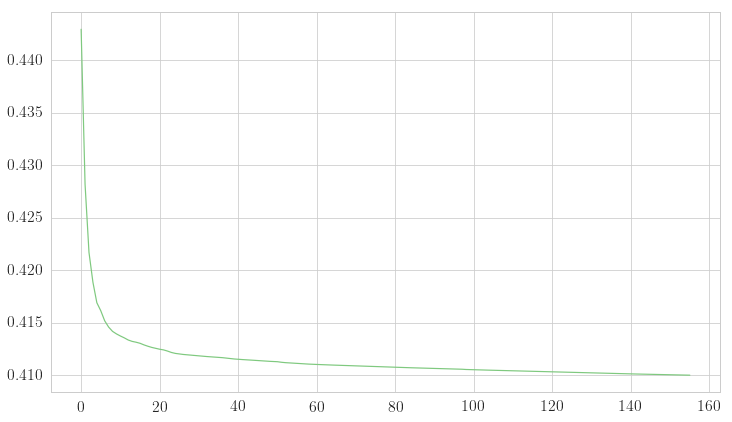

In [156]:
plt.plot(est.train_score_)

In [157]:
est.n_estimators

156

In [160]:
est.n_features_

32

In [161]:
[el for el in dir(gbc) if (el.endswith('_') and not el.startswith('_'))] 

['best_estimator_',
 'best_index_',
 'best_params_',
 'best_score_',
 'classes_',
 'cv_results_',
 'grid_scores_',
 'multimetric_',
 'n_splits_',
 'scorer_']

In [166]:
ds = pd.DataFrame(gbc.cv_results_)

In [172]:
print(*ds.columns, sep='\n')

mean_fit_time
mean_score_time
mean_test_score
mean_train_score
param_learning_rate
param_max_depth
param_n_estimators
params
rank_test_score
split0_test_score
split0_train_score
split1_test_score
split1_train_score
split2_test_score
split2_train_score
split3_test_score
split3_train_score
std_fit_time
std_score_time
std_test_score
std_train_score


In [219]:
ds2 = ds.copy()
ds2 = ds2.rename(columns = misc.snake2word(ds2.columns)) 

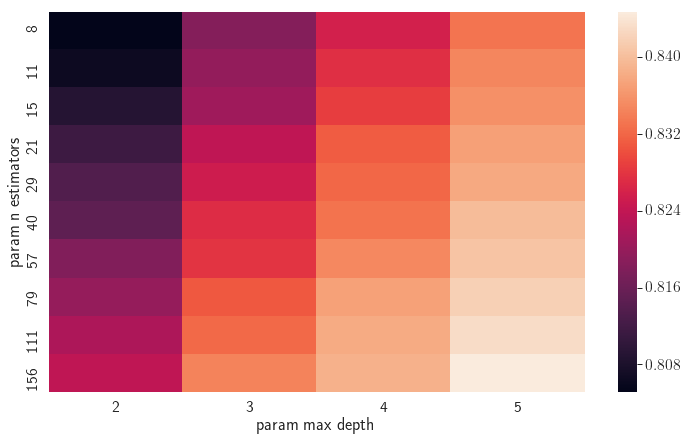

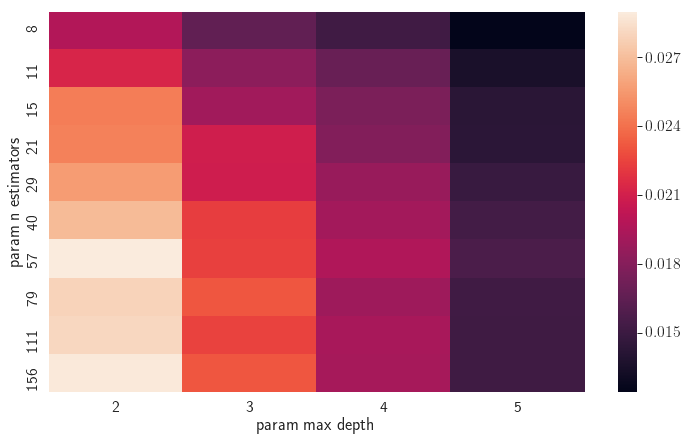

In [234]:
ds2g1 = ds2.groupby(['param n estimators', 'param max depth'])['mean test score'].mean().unstack() 
ds2g1s = ds2.groupby(['param n estimators', 'param max depth'])['mean test score'].std().unstack() 
fig, ax = plt.subplots()
sns.heatmap(ds2g1) 
fig, ax = plt.subplots()
sns.heatmap(ds2g1s) 

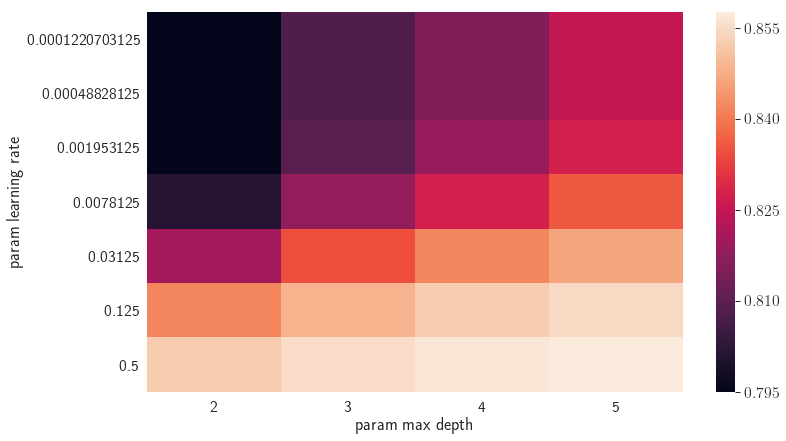

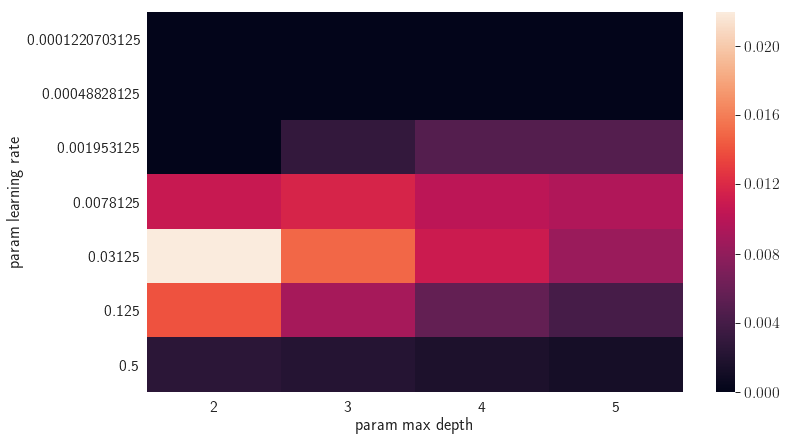

In [235]:
ds2g2 = ds2.groupby(['param learning rate', 'param max depth'])['mean test score'].mean().unstack() 
ds2g2s = ds2.groupby(['param learning rate', 'param max depth'])['mean test score'].std().unstack() 
fig, ax = plt.subplots()
sns.heatmap(ds2g2) 
fig, ax = plt.subplots()
sns.heatmap(ds2g2s) 